In [1]:
# import libraries
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torchsummary import summary

In [29]:
import sys
sys.path.append("../")
sys.path.append("../../")

import os
import random
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from predict import predict
from open_data import open_data, create_global_batch,get_df_stats,apply_norm
from dataset import RadarDataset,RadarCollate
from simple_model import LSTM
from bayesian_lstm_model import BayesLSTM
from train import train
import constant

In [3]:
PATH_CSV= "/Users/clemencevast/Documents/Courses/MachineLearning/RadarTrafficData_files/Radar_Traffic_Counts.csv" #"/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv"
radar_name=' CAPITAL OF TEXAS HWY / LAKEWOOD DR'
DAYS_INPUT=7
WINDOW_LABEL=7
INPUT_SIZE=(DAYS_INPUT)*24*4 # 7*24*4 = 672
OUTPUT_SIZE=(WINDOW_LABEL)*24*4 # 7*24*4 = 672
TOTAL_DAYS=365

In [4]:
df1=open_data(PATH_CSV, direction="NB", radar=radar_name, year=2018)

In [5]:
batch_df=create_global_batch(df1, window_x_day=DAYS_INPUT, window_label_day=WINDOW_LABEL, gap_acquisition=1, tot_len_day=TOTAL_DAYS)

Building batch 0 
 x begin 2018-01-02 label begin 2018-01-09 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-03 label begin 2018-01-10 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-04 label begin 2018-01-11 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-05 label begin 2018-01-12 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-06 label begin 2018-01-13 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-07 label begin 2018-01-14 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-08 label begin 2018-01-15 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-09 label begin 2018-01-16 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-10 label begin 2018-01-17 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-11 label begin 2018-01-18 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-12 label begin 2018-01-19 end period 2018-12-16 
Building batch 0 
 x begin 2018-01-13 label begin 2018-01-20 end period 2018

In [6]:
batch_df

,vol_data_x,vol_label_y
0,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38.0, 38.0, 26.0, 21.0, 26.0, 22.0, 18.0, 11...."
1,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35.0, 35.0, 35.0, 23.0, 23.0, 14.0, 13.0, 13...."
2,"[32.0, 25.0, 20.0, 25.0, 20.0, 19.0, 18.0, 8.0...","[38.0, 34.0, 32.0, 23.0, 29.0, 15.0, 22.0, 16...."
3,"[56.0, 54.0, 41.0, 39.0, 27.0, 28.0, 32.0, 17....","[83.0, 64.0, 45.0, 47.0, 29.0, 37.0, 26.0, 24...."
4,"[75.0, 62.0, 49.0, 42.0, 42.0, 44.0, 27.0, 23....","[80.0, 65.0, 59.0, 64.0, 42.0, 37.0, 32.0, 27...."
...,...,...
120,"[33, 26, 16, 25, 19, 19, 21, 15, 13, 12, 8, 10...","[44, 35, 31, 26, 12, 16, 26, 11, 14, 13, 6, 11..."
121,"[50, 20, 29, 35, 12, 11, 24, 12, 13, 12, 9, 7,...","[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ..."
122,"[44, 32, 37, 19, 33, 19, 21, 13, 15, 8, 13, 14...","[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,..."
123,"[80, 52, 66, 41, 47, 25, 28, 32, 24, 15, 14, 1...","[70, 63, 57, 46, 38, 33, 25, 30, 24, 16, 10, 1..."


In [7]:
#batch_df["mean_x"]=batch_df["vol_data_x"].apply(lambda x : np.mean(x))
#batch_df["std_x"]=batch_df["vol_data_x"].apply(lambda x : np.std(x))
#batch_df["mean_y"]=batch_df["vol_label_y"].apply(lambda x : np.mean(x))
# batch_df

In [8]:
df_mean,df_std=get_df_stats(batch_df)
new_data=apply_norm(batch_df,df_mean,df_std)


In [9]:
get_df_stats(new_data,["vol_data_x_norm","vol_label_y_norm"])

(0.0, 1.0)

In [10]:
batch_df

,vol_data_x,vol_label_y,vol_data_x_min,vol_data_x_max,vol_label_y_min,vol_label_y_max,vol_data_x_norm,vol_label_y_norm,vol_data_x_norm_min,vol_data_x_norm_max,vol_label_y_norm_min,vol_label_y_norm_max
0,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38.0, 38.0, 26.0, 21.0, 26.0, 22.0, 18.0, 11....",0.0,789.0,0.0,635.0,"[0.013360739979445015, 0.0051387461459403904, ...","[0.03905447070914697, 0.03905447070914697, 0.0...",0.000000,0.810894,0.000000,0.652621
1,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35.0, 35.0, 35.0, 23.0, 23.0, 14.0, 13.0, 13....",0.0,505.0,0.0,635.0,"[0.03494347379239465, 0.029804727646454265, 0....","[0.03597122302158273, 0.03597122302158273, 0.0...",0.000000,0.519013,0.000000,0.652621
2,"[32.0, 25.0, 20.0, 25.0, 20.0, 19.0, 18.0, 8.0...","[38.0, 34.0, 32.0, 23.0, 29.0, 15.0, 22.0, 16....",0.0,635.0,0.0,499.0,"[0.0328879753340185, 0.025693730729701953, 0.0...","[0.03905447070914697, 0.03494347379239465, 0.0...",0.000000,0.652621,0.000000,0.512847
3,"[56.0, 54.0, 41.0, 39.0, 27.0, 28.0, 32.0, 17....","[83.0, 64.0, 45.0, 47.0, 29.0, 37.0, 26.0, 24....",0.0,635.0,0.0,499.0,"[0.05755395683453238, 0.05549845837615622, 0.0...","[0.08530318602261049, 0.065775950668037, 0.046...",0.000000,0.652621,0.000000,0.512847
4,"[75.0, 62.0, 49.0, 42.0, 42.0, 44.0, 27.0, 23....","[80.0, 65.0, 59.0, 64.0, 42.0, 37.0, 32.0, 27....",0.0,635.0,0.0,499.0,"[0.07708119218910586, 0.06372045220966084, 0.0...","[0.08221993833504625, 0.06680369989722508, 0.0...",0.000000,0.652621,0.000000,0.512847
...,...,...,...,...,...,...,...,...,...,...,...,...
120,"[33, 26, 16, 25, 19, 19, 21, 15, 13, 12, 8, 10...","[44, 35, 31, 26, 12, 16, 26, 11, 14, 13, 6, 11...",4.0,510.0,3.0,488.0,"[0.03391572456320658, 0.02672147995889003, 0.0...","[0.045220966084275435, 0.03597122302158273, 0....",0.004111,0.524152,0.003083,0.501542
121,"[50, 20, 29, 35, 12, 11, 24, 12, 13, 12, 9, 7,...","[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...",4.0,487.0,3.0,488.0,"[0.051387461459403906, 0.020554984583761562, 0...","[0.05960945529290853, 0.02877697841726619, 0.0...",0.004111,0.500514,0.003083,0.501542
122,"[44, 32, 37, 19, 33, 19, 21, 13, 15, 8, 13, 14...","[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...",4.0,487.0,3.0,501.0,"[0.045220966084275435, 0.0328879753340185, 0.0...","[0.051387461459403906, 0.041109969167523124, 0...",0.004111,0.500514,0.003083,0.514902
123,"[80, 52, 66, 41, 47, 25, 28, 32, 24, 15, 14, 1...","[70, 63, 57, 46, 38, 33, 25, 30, 24, 16, 10, 1...",4.0,487.0,3.0,501.0,"[0.08221993833504625, 0.05344295991778006, 0.0...","[0.07194244604316546, 0.06474820143884892, 0.0...",0.004111,0.500514,0.003083,0.514902


In [11]:
new_data

,vol_data_x,vol_label_y,vol_data_x_min,vol_data_x_max,vol_label_y_min,vol_label_y_max,vol_data_x_norm,vol_label_y_norm,vol_data_x_norm_min,vol_data_x_norm_max,vol_label_y_norm_min,vol_label_y_norm_max
0,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38.0, 38.0, 26.0, 21.0, 26.0, 22.0, 18.0, 11....",0.0,789.0,0.0,635.0,"[0.013360739979445015, 0.0051387461459403904, ...","[0.03905447070914697, 0.03905447070914697, 0.0...",0.000000,0.810894,0.000000,0.652621
1,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35.0, 35.0, 35.0, 23.0, 23.0, 14.0, 13.0, 13....",0.0,505.0,0.0,635.0,"[0.03494347379239465, 0.029804727646454265, 0....","[0.03597122302158273, 0.03597122302158273, 0.0...",0.000000,0.519013,0.000000,0.652621
2,"[32.0, 25.0, 20.0, 25.0, 20.0, 19.0, 18.0, 8.0...","[38.0, 34.0, 32.0, 23.0, 29.0, 15.0, 22.0, 16....",0.0,635.0,0.0,499.0,"[0.0328879753340185, 0.025693730729701953, 0.0...","[0.03905447070914697, 0.03494347379239465, 0.0...",0.000000,0.652621,0.000000,0.512847
3,"[56.0, 54.0, 41.0, 39.0, 27.0, 28.0, 32.0, 17....","[83.0, 64.0, 45.0, 47.0, 29.0, 37.0, 26.0, 24....",0.0,635.0,0.0,499.0,"[0.05755395683453238, 0.05549845837615622, 0.0...","[0.08530318602261049, 0.065775950668037, 0.046...",0.000000,0.652621,0.000000,0.512847
4,"[75.0, 62.0, 49.0, 42.0, 42.0, 44.0, 27.0, 23....","[80.0, 65.0, 59.0, 64.0, 42.0, 37.0, 32.0, 27....",0.0,635.0,0.0,499.0,"[0.07708119218910586, 0.06372045220966084, 0.0...","[0.08221993833504625, 0.06680369989722508, 0.0...",0.000000,0.652621,0.000000,0.512847
...,...,...,...,...,...,...,...,...,...,...,...,...
120,"[33, 26, 16, 25, 19, 19, 21, 15, 13, 12, 8, 10...","[44, 35, 31, 26, 12, 16, 26, 11, 14, 13, 6, 11...",4.0,510.0,3.0,488.0,"[0.03391572456320658, 0.02672147995889003, 0.0...","[0.045220966084275435, 0.03597122302158273, 0....",0.004111,0.524152,0.003083,0.501542
121,"[50, 20, 29, 35, 12, 11, 24, 12, 13, 12, 9, 7,...","[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...",4.0,487.0,3.0,488.0,"[0.051387461459403906, 0.020554984583761562, 0...","[0.05960945529290853, 0.02877697841726619, 0.0...",0.004111,0.500514,0.003083,0.501542
122,"[44, 32, 37, 19, 33, 19, 21, 13, 15, 8, 13, 14...","[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...",4.0,487.0,3.0,501.0,"[0.045220966084275435, 0.0328879753340185, 0.0...","[0.051387461459403906, 0.041109969167523124, 0...",0.004111,0.500514,0.003083,0.514902
123,"[80, 52, 66, 41, 47, 25, 28, 32, 24, 15, 14, 1...","[70, 63, 57, 46, 38, 33, 25, 30, 24, 16, 10, 1...",4.0,487.0,3.0,501.0,"[0.08221993833504625, 0.05344295991778006, 0.0...","[0.07194244604316546, 0.06474820143884892, 0.0...",0.004111,0.500514,0.003083,0.514902


In [12]:
#get_df_stats(new_data,columns=["vol_data_x_norm","vol_label_y_norm"])

In [13]:
# sample_rate = 16000
batch_size = 1

In [14]:
#normalize=transforms.Compose([
#    transforms.ToTensor(),
  #  transforms.Normalize(mean=[df_mean],
                       #  std=[df_std])
#])
fullset = RadarDataset(dataframe=batch_df,transform=None)
ptrain,pval,ptest=0.8,0.05,0.15
trainglobdataset, testdataset = train_test_split(fullset, test_size=ptest,shuffle=False)
traindataset, valdataset = train_test_split(trainglobdataset, test_size=pval/(1-ptest),shuffle=False)

(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)


In [15]:
collate_fn = RadarCollate()
trainloader = DataLoader(traindataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valloader = DataLoader(valdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
testloader = DataLoader(testdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [16]:
print(traindataset)

[(array([0.01336074, 0.00513875, 0.01438849, 0.01541624, 0.00924974,
       0.004111  , 0.0061665 , 0.00102775, 0.004111  , 0.00102775,
       0.00513875, 0.0020555 , 0.004111  , 0.0061665 , 0.00513875,
       0.00308325, 0.00719424, 0.00822199, 0.01233299, 0.01336074,
       0.02363823, 0.02569373, 0.03186023, 0.05858171, 0.07913669,
       0.09146968, 0.1336074 , 0.16032888, 0.22302158, 0.28057554,
       0.29496403, 0.43371017, 0.3987667 , 0.34532374, 0.41521069,
       0.39362795, 0.45837616, 0.4614594 , 0.47687564, 0.50154162,
       0.47893114, 0.45015416, 0.38232271, 0.38437821, 0.39260021,
       0.41212744, 0.43268243, 0.44193217, 0.3987667 , 0.38540596,
       0.4028777 , 0.42137718, 0.38746146, 0.36073998, 0.39054471,
       0.4028777 , 0.38643371, 0.37923947, 0.3946557 , 0.81089414,
       0.38437821, 0.44193217, 0.4008222 , 0.48098664, 0.45734841,
       0.26824255, 0.30113052, 0.27749229, 0.06783145, 0.06372045,
       0.04727646, 0.05652621, 0.0626927 , 0.25693731, 0.283

In [17]:
c= 0
for x in trainloader:
    print("batch number {}".format(c))
    print(x[0].shape, x[1].shape, "\n")
    #print(x)
    c+=1

batch number 0
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 1
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 2
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 3
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 4
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 5
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 6
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 7
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 8
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 9
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 10
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 11
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 12
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 13
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 14
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 15
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 16
torch.Size([1, 672]) torch.Size([1

## Modèle Bayesian

In [18]:
input_dim = INPUT_SIZE   
hidden_dim = 256
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1

lr2 = 0.001
n_epochs = 700
iterations_per_epoch = len(trainloader)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=BayesLSTM()
name_model="bayesian_model_smalldataset_lre-3"


In [19]:
iteration2,loss_train_list2,loss_val_list2=train(model, trainloader, valloader, lr=lr2, n_epochs=n_epochs, name_model=name_model, device=device,ite_print=2,save=True)

/Users/clemencevast/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 672])) that is different to the input size (torch.Size([672])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 loss train 0.0060633281245827675 loss val 0.004949626978486776
epoch 3 loss train 0.004255721811205149 loss val 0.0037058230955153704
epoch 5 loss train 0.0026273243129253387 loss val 0.0031534056179225445
epoch 7 loss train 0.004848495125770569 loss val 0.0030172558035701513
epoch 9 loss train 0.002623600885272026 loss val 0.002816122490912676
epoch 11 loss train 0.003576731076464057 loss val 0.0027745175175368786
epoch 13 loss train 0.0027731400914490223 loss val 0.002945032436400652
epoch 15 loss train 0.0027620727196335793 loss val 0.00271621230058372
epoch 17 loss train 0.002830384997650981 loss val 0.0026897366624325514
epoch 19 loss train 0.0033608446829020977 loss val 0.002908900147303939
epoch 21 loss train 0.003436000319197774 loss val 0.00263816281221807
epoch 23 loss train 0.0026940612588077784 loss val 0.002709483029320836
epoch 25 loss train 0.0030374492052942514 loss val 0.0027152278926223516
epoch 27 loss train 0.0028324213344603777 loss val 0.002827731659635901

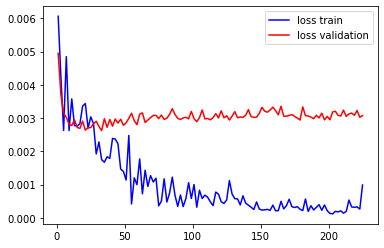

In [26]:
fig,ax=plt.subplots()
ax.plot(iteration2,loss_train_list2,"b",label="loss train")
ax.plot(iteration2,loss_val_list2,"r",label="loss validation")
ax.legend()

In [28]:
# fig,ax=plt.subplots()
# ax.set_title("Ssimple model")
# ax.plot(iteration,loss_val_list,"green",label="loss validation lr 5e-2")
# ax.plot(iteration2,loss_val_list2,"r",label="loss validation lr 1e-3")
# ax.legend()

In [31]:
PATH_MODEL= constant.MODEL_DIR + name_model +".pt"
prediction, gt, mse_list=predict(PATH_MODEL,testloader)

/Users/clemencevast/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 672])) that is different to the input size (torch.Size([672])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [45]:
def get_confidence_intervals(preds_test, ci_multiplier):
#     global scaler
    
#     preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
#     pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
#     upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
#     lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

In [46]:
# print(prediction)
# print(gt)

In [47]:
ci_multiplier=10
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(prediction,
                                                                                          ci_multiplier)

AttributeError: 'list' object has no attribute 'mean'

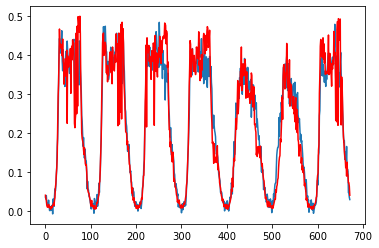

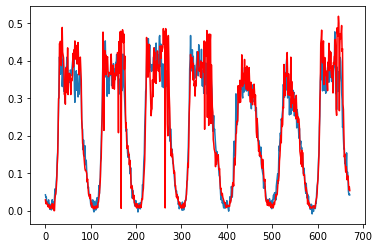

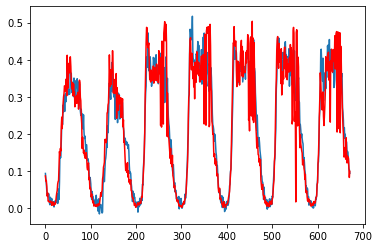

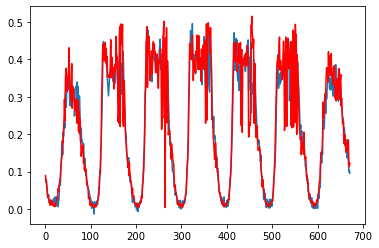

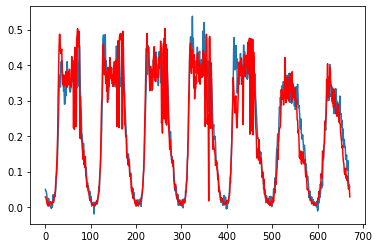

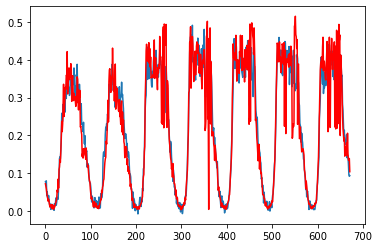

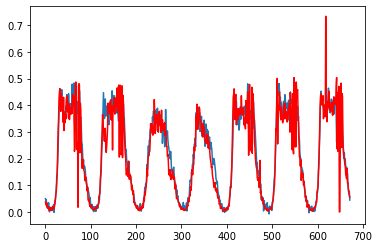

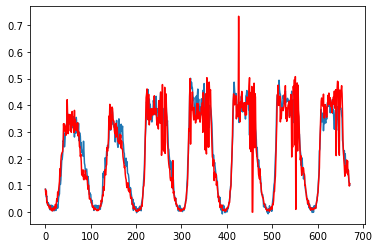

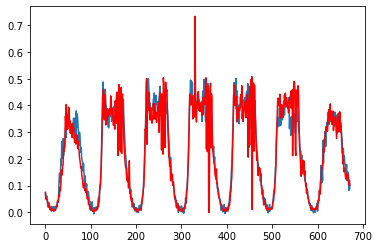

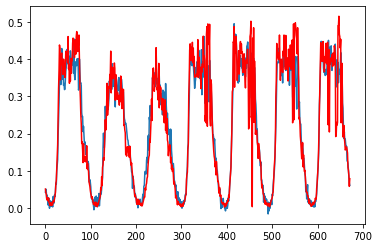

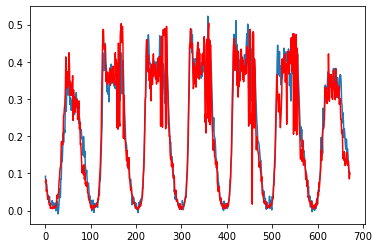

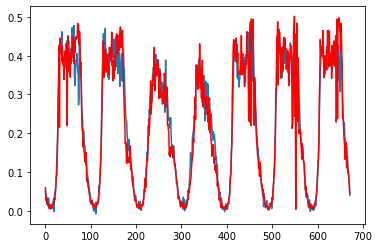

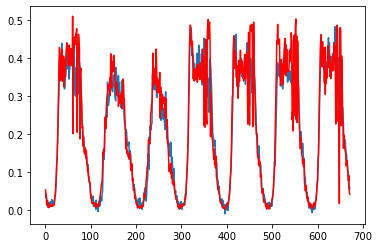

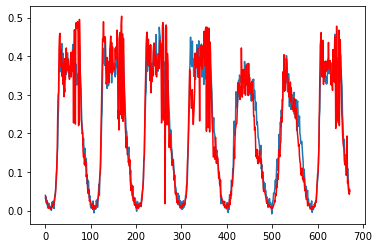

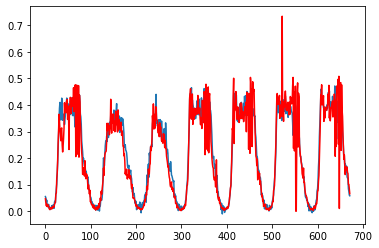

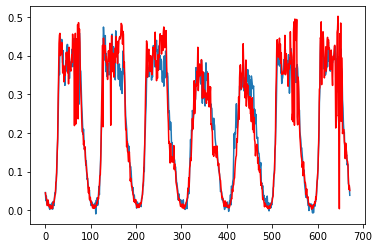

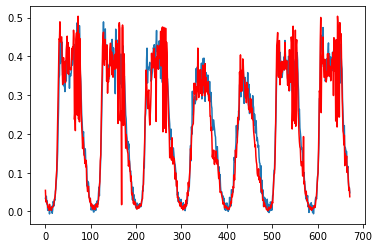

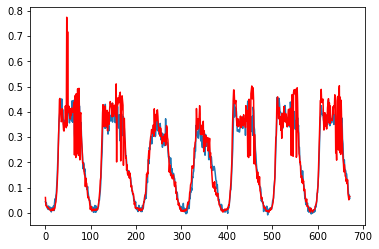

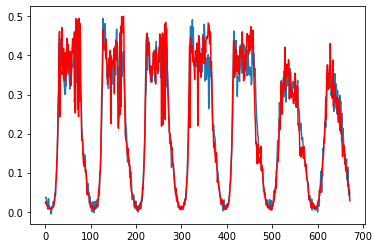

In [48]:
for i in range(19):
    fig,ax=plt.subplots()
    arr_pred=prediction[i].detach().numpy()
    ax.plot([i for i in range(len(arr_pred))],arr_pred)
    arr_gt=gt[i].detach().numpy()
    ax.plot([i for i in range(len(arr_pred))],arr_gt.ravel(),"r")